In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

In [4]:
filepath = 'sampledata1.csv'
macro_data = pd.read_csv(filepath, parse_dates=['Year'], index_col='Year')
print(macro_data.shape)  # (61,3)
macro_data.head()

(61, 3)


,TempMean,PrecipMean,Product
Year,,,
1960-01-01,27.1,32.4,4203000
1961-01-01,27.1,32.5,4279000
1962-01-01,27.2,32.4,4304000
1963-01-01,27.4,32.8,4453700
1964-01-01,27.4,32.9,4561100


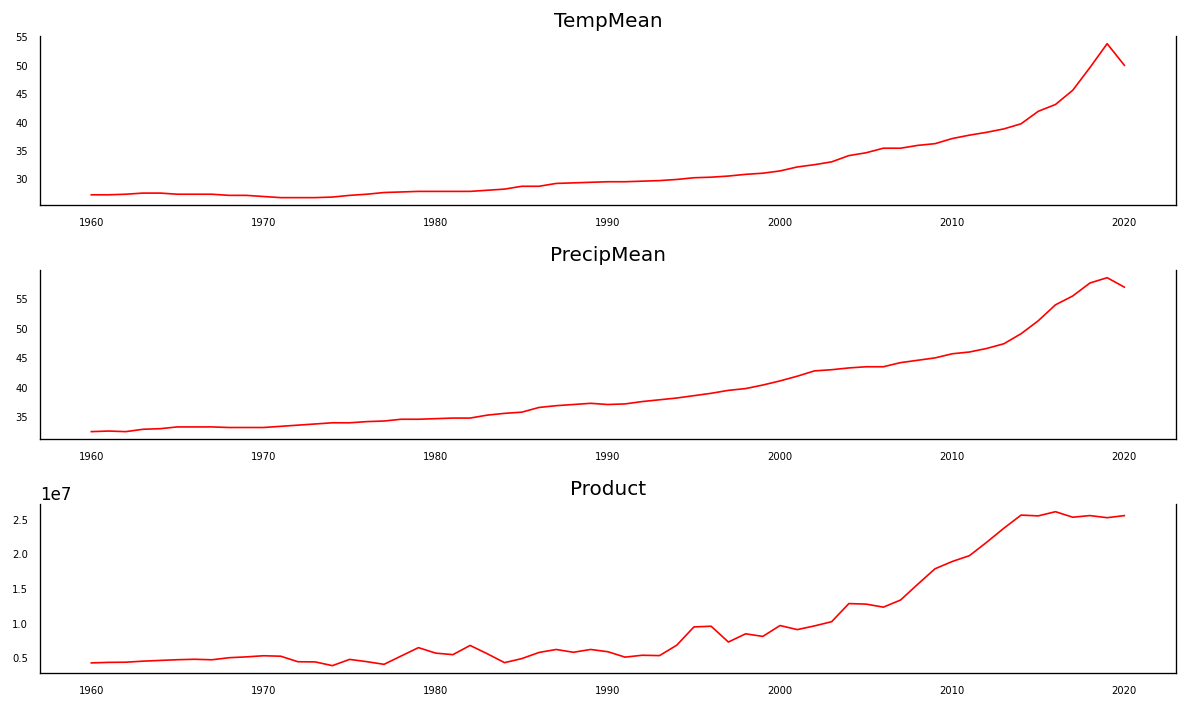

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [7]:
ad_fuller_result_1 = adfuller(macro_data['PrecipMean'].diff()[1:])

print('realPrecip')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['TempMean'].diff()[1:])

print('realTemp')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realPrecip
ADF Statistic: -4.97538870715405
p-value: 2.4821593369762808e-05

---------------------

realTemp
ADF Statistic: 1.2924172803343523
p-value: 0.9965661404963895


In [8]:
print('Precipitation causes Temperature Flactuation?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['TempMean', 'PrecipMean']], 4)

print('\nTemperature Rise&Fall causes Precipitation(Changes with Rainfall amount)?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['PrecipMean', 'TempMean']], 4)

Precipitation causes Temperature Flactuation?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.6973 , p=0.0001  , df_denom=57, df_num=1
ssr based chi2 test:   chi2=19.6814 , p=0.0000  , df=1
likelihood ratio test: chi2=17.0215 , p=0.0000  , df=1
parameter F test:         F=18.6973 , p=0.0001  , df_denom=57, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=18.7738 , p=0.0000  , df_denom=54, df_num=2
ssr based chi2 test:   chi2=41.0242 , p=0.0000  , df=2
likelihood ratio test: chi2=31.1446 , p=0.0000  , df=2
parameter F test:         F=18.7738 , p=0.0000  , df_denom=54, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.1594 , p=0.0000  , df_denom=51, df_num=3
ssr based chi2 test:   chi2=41.4850 , p=0.0000  , df=3
likelihood ratio test: chi2=31.2947 , p=0.0000  , df=3
parameter F test:         F=12.1594 , p=0.0000  , df_denom=51, df_num=3

Granger Causality
number of lags 

In [9]:
macro_data = macro_data[['TempMean','PrecipMean']]
print(macro_data.shape)

(61, 2)


In [10]:
train_df=macro_data[:-6]
test_df=macro_data[-6:]

In [11]:
print(test_df.shape)

(6, 2)


In [12]:
model = VAR(train_df.diff()[1:])

In [14]:
sorted_order=model.select_order(maxlags=10) #20 was too large for the number of observations. (Ask why? and What it means.)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -4.862      -4.781    0.007737      -4.832
1       -5.422     -5.179*    0.004421      -5.332
2       -5.560      -5.155   0.003855*     -5.410*
3       -5.392      -4.824    0.004579      -5.181
4       -5.538      -4.808    0.003982      -5.267
5       -5.479      -4.587    0.004267      -5.148
6       -5.379      -4.324    0.004784      -4.988
7       -5.207      -3.990    0.005800      -4.756
8       -5.220      -3.842    0.005882      -4.709
9       -5.392      -3.851    0.005142      -4.820
10     -5.601*      -3.898    0.004374      -4.969
--------------------------------------------------


In [15]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                               Statespace Model Results                               
Dep. Variable:     ['TempMean', 'PrecipMean']   No. Observations:                   55
Model:                                 VAR(4)   Log Likelihood                -178.215
                                  + intercept   AIC                            398.429
Date:                        Tue, 17 May 2022   BIC                            440.583
Time:                                11:02:10   HQIC                           414.730
Sample:                            01-01-1960                                         
                                 - 01-01-2014                                         
Covariance Type:                          opg                                         
Ljung-Box (L1) (Q):           33.90, 27.84   Jarque-Bera (JB):         19.12, 20.03
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         4.41, 3.70   Skew

In [16]:
n_forecast = 6
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#

predictions=predict.predicted_mean

In [18]:
predictions.columns=['TempMean_predicted','PrecipMean_predicted']
predictions

,TempMean_predicted,PrecipMean_predicted
2015-01-01,28.600273,34.876088
2016-01-01,25.571418,30.551057
2017-01-01,22.363031,26.018470
2018-01-01,21.593913,24.920384
2019-01-01,27.361607,32.192995
2020-01-01,28.544093,34.141778


In [19]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<AxesSubplot:>

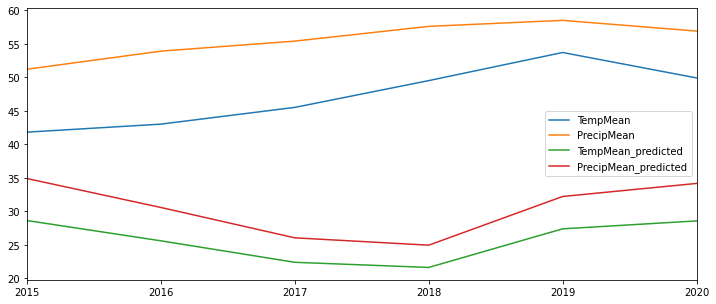

In [20]:
test_vs_pred.plot(figsize=(12,5))

In [22]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

rmse_ulc=math.sqrt(mean_squared_error(predictions['TempMean_predicted'],test_df['TempMean']))
print('Mean value of TempMean is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['TempMean']),rmse_ulc))

rmse_rgnp=math.sqrt(mean_squared_error(predictions['PrecipMean_predicted'],test_df['PrecipMean']))
print('Mean value of PrecipMean is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['PrecipMean']),rmse_rgnp))

Mean value of TempMean is : 47.233333333333334. Root Mean Squared Error is :22.142880673459008
Mean value of PrecipMean is : 55.583333333333336. Root Mean Squared Error is :25.667326998848907


==============================================================================================================================

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')


In [4]:
filepath = 'sampledata1.csv'
macro_data = pd.read_csv(filepath, parse_dates=['Year'], index_col='Year')
print(macro_data.shape)  # (61,3)
macro_data.head()
macro_data

(61, 3)


,TempMean,PrecipMean,Product
Year,,,
1960-01-01,27.1,32.4,4203000
1961-01-01,27.1,32.5,4279000
1962-01-01,27.2,32.4,4304000
1963-01-01,27.4,32.8,4453700
1964-01-01,27.4,32.9,4561100
...,...,...,...
2016-01-01,43.0,53.9,25987204
2017-01-01,45.5,55.4,25191722
2018-01-01,49.5,57.6,25428204


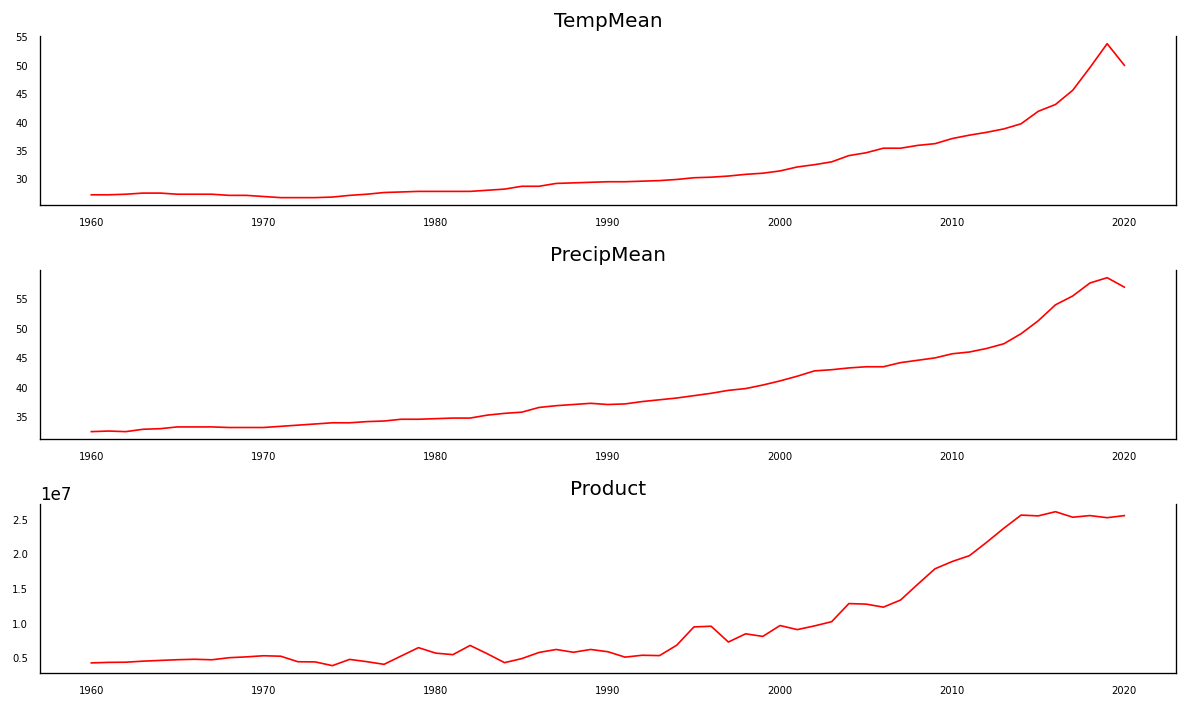

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [7]:
ad_fuller_result_1 = adfuller(macro_data['PrecipMean'].diff()[1:])

print('realPrecip')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['Product'].diff()[1:])

print('Product')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realPrecip
ADF Statistic: -4.97538870715405
p-value: 2.4821593369762808e-05

---------------------

Product
ADF Statistic: -6.2581308381963625
p-value: 4.28863820253128e-08


In [8]:
print('Precipitation causes Product Flactuation?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['Product', 'PrecipMean']], 4)

print('\nProduct Rise&Fall causes Precipitation(Changes with Rainfall amount)?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['PrecipMean', 'Product']], 4)

Precipitation causes Product Flactuation?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4699  , df_denom=57, df_num=1
ssr based chi2 test:   chi2=0.5572  , p=0.4554  , df=1
likelihood ratio test: chi2=0.5546  , p=0.4564  , df=1
parameter F test:         F=0.5293  , p=0.4699  , df_denom=57, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4707  , p=0.0940  , df_denom=54, df_num=2
ssr based chi2 test:   chi2=5.3988  , p=0.0672  , df=2
likelihood ratio test: chi2=5.1659  , p=0.0755  , df=2
parameter F test:         F=2.4707  , p=0.0940  , df_denom=54, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2180  , p=0.0973  , df_denom=51, df_num=3
ssr based chi2 test:   chi2=7.5674  , p=0.0559  , df=3
likelihood ratio test: chi2=7.1128  , p=0.0684  , df=3
parameter F test:         F=2.2180  , p=0.0973  , df_denom=51, df_num=3

Granger Causality
number of lags (no 

In [9]:
macro_data = macro_data[['PrecipMean','Product']]
print(macro_data.shape)

(61, 2)


In [10]:
train_df=macro_data[:-6]
test_df=macro_data[-6:]

In [11]:
print(test_df.shape)

(6, 2)


In [12]:
model = VAR(train_df.diff()[1:])

In [13]:
sorted_order=model.select_order(maxlags=10) #20 was too large for the number of observations. (Ask why? and What it means.)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        25.57       25.66   1.279e+11       25.60
1        25.39      25.64*   1.066e+11      25.48*
2        25.48       25.88   1.164e+11       25.63
3        25.64       26.21   1.373e+11       25.85
4        25.57       26.30   1.286e+11       25.84
5        25.53       26.42   1.252e+11       25.86
6        25.42       26.47   1.132e+11       25.81
7        25.27       26.48   9.941e+10       25.72
8       25.15*       26.53  9.097e+10*       25.66
9        25.16       26.70   9.565e+10       25.73
10       25.28       26.98   1.129e+11       25.91
--------------------------------------------------


In [19]:
var_model = VARMAX(train_df, order=(1,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                               Statespace Model Results                              
Dep. Variable:     ['PrecipMean', 'Product']   No. Observations:                   55
Model:                                VAR(1)   Log Likelihood                -968.321
                                 + intercept   AIC                           1954.642
Date:                       Wed, 18 May 2022   BIC                           1972.708
Time:                               15:12:09   HQIC                          1961.628
Sample:                           01-01-1960                                         
                                - 01-01-2014                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):            43.28, 2.86   Jarque-Bera (JB):           3.91, 0.67
Prob(Q):                        0.00, 0.09   Prob(JB):                   0.14, 0.72
Heteroskedasticity (H):        1.56, 10.91   Skew:        

In [20]:
n_forecast = 6
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#

predictions=predict.predicted_mean

In [21]:
predictions.columns=['PrecipMean_predicted','Product_predicted']
predictions

,PrecipMean_predicted,Product_predicted
2015-01-01,54.329060,2.649679e+07
2016-01-01,54.279324,2.632928e+07
2017-01-01,54.110948,2.613832e+07
2018-01-01,53.942449,2.594969e+07
2019-01-01,53.776459,2.576392e+07
2020-01-01,53.613000,2.558098e+07


In [22]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<AxesSubplot:>

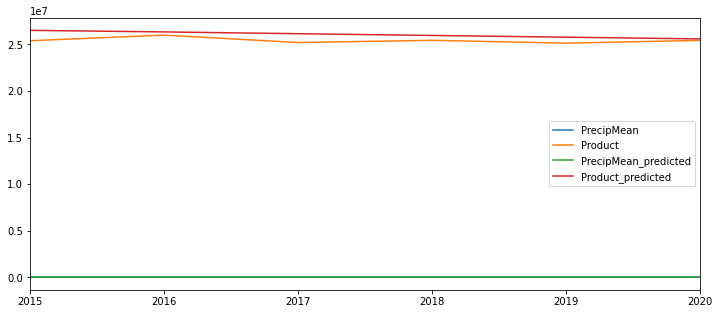

In [23]:
test_vs_pred.plot(figsize=(12,5))

---------------------------------------------------------------------------------------------------------------------